In [ ]:
!git clone https://gitlab.com/sayantan.world98/sentiment-analysis-amazon-health-and-personal-care.git

fatal: destination path 'sentiment-analysis-amazon-health-and-personal-care' already exists and is not an empty directory.


In [ ]:
# DataFrame
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk                                 #NLTK provides various tools and resources for text processing and NLP
from nltk.stem import WordNetLemmatizer     #  used for lemmatization (reducing words to their base forms)
from nltk.corpus import stopwords           #contains a list of common stopwords
from nltk.tokenize import word_tokenize     # used for tokenizing text into words

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer #  uses the frequency of words to determine how relevant those words are to a given document.
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

#tensorflow
#import tensorflow.compat.v2 as tf
#import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re # regular expression
import string  # string manipulation
import pickle   #

In [ ]:
# Loading the dataset in a dataframe
df = pd.read_json('/content/sentiment-analysis-amazon-health-and-personal-care/dataset/Health_and_Personal_Care_5.json', lines=True)

In [ ]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5,Very nice and convenient.,1313452800,"08 16, 2011"


In [ ]:
df['overall'].value_counts()

,count
overall,
5,211633
4,68168
3,33254
2,16754
1,16546


In [ ]:
#check the number of positive vs. negative tagged sentences, we ignore neutral reviews as of now
positives = df['overall'][(df.overall == 5) | (df.overall == 4)]
negatives = df['overall'][(df.overall == 2) | (df.overall == 1)]
print('Total length of the data is:         {}'.format(df.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         346355
No. of positve tagged sentences is:  279801
No. of negative tagged sentences is: 33300


In [ ]:
# We use this to give a weight to the helpful reviews and we also applied smoothing.
#helpful: [the number of helpful votes, the total number of votes]
df['score'] = df.helpful.apply(lambda x: x[0] / (x[1] + 2)) # calculates a "score" for each review based on its helpfulness
# sample 32000 pos and neg

df_pos = df[(df.overall == 5) | (df.overall == 4)]
df_pos = df_pos.sample(n=32000, weights=df.score, random_state=42) #more helpful reviews are more likely to be included in the sample
df_neg = df[(df.overall == 2) | (df.overall == 1)]
df_neg = df_neg.sample(n=32000, random_state=42)

In [ ]:
df_all = pd.concat([df_pos, df_neg])

In [ ]:
# Positive class - 1, Negative class - 0
def sentiment_score(n):
  if n == 5 or n == 4:
    return 1
  return 0

df_all['overall']=df_all['overall'].apply(lambda x: sentiment_score(x))

In [ ]:
df_all['overall'].value_counts()

,count
overall,
1,32000
0,32000


In [ ]:
df_all.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,score
114050,A2O7GDWNVZIZNP,B0018M757K,Karen,"[10, 11]","My stepdad needed a shower chair, and the ones...",1,"so nice, I ordered one for my mother in law",1318377600,"10 12, 2011",0.769231
329492,A1UEON4FAT753R,B00FA35K02,joseph,"[2, 2]",It works. However it had a lot of bubbles ins...,1,"Cheap, but does the job",1401321600,"05 29, 2014",0.500000
245270,A1ZVJ9Q99OBL66,B00537E45W,"ANGELINA VAQUERA-LINKE ""A relocated Southerne...","[8, 9]",We bought these for my 8 year old with high-fu...,1,Autism support,1297900800,"02 17, 2011",0.727273
195288,A3NGOG8Z78AZSD,B003A013QW,Edward Barnett,"[1, 2]",I've owned a front-loader (HE) washing machine...,1,Better than bleach -- worked great for me,1364601600,"03 30, 2013",0.250000
46761,A2SS8MC8XZWTYJ,B000FA05Y6,Supermuv,"[1, 1]","Good value for use in the home; not too big, n...",1,good value,1384128000,"11 11, 2013",0.333333


In [ ]:
df_all = df_all.drop(['reviewerName', 'helpful', 'unixReviewTime', 'reviewTime', 'score', 'summary', 'asin', 'reviewerID'], axis=1)

In [ ]:
df_all.head()

,reviewText,overall
114050,"My stepdad needed a shower chair, and the ones...",1
329492,It works. However it had a lot of bubbles ins...,1
245270,We bought these for my 8 year old with high-fu...,1
195288,I've owned a front-loader (HE) washing machine...,1
46761,"Good value for use in the home; not too big, n...",1


In [ ]:
# Reset index
df_all.reset_index().drop(['index'], axis=1)

,reviewText,overall
0,"My stepdad needed a shower chair, and the ones...",1
1,It works. However it had a lot of bubbles ins...,1
2,We bought these for my 8 year old with high-fu...,1
3,I've owned a front-loader (HE) washing machine...,1
4,"Good value for use in the home; not too big, n...",1
...,...,...
63995,Picked up a pair of Duracell AA batteries on a...,0
63996,This dried up after only one or two sparse use...,0
63997,I had dislocated and broken my shoulder nearly...,0
63998,When I was a child I remember reading a short ...,0


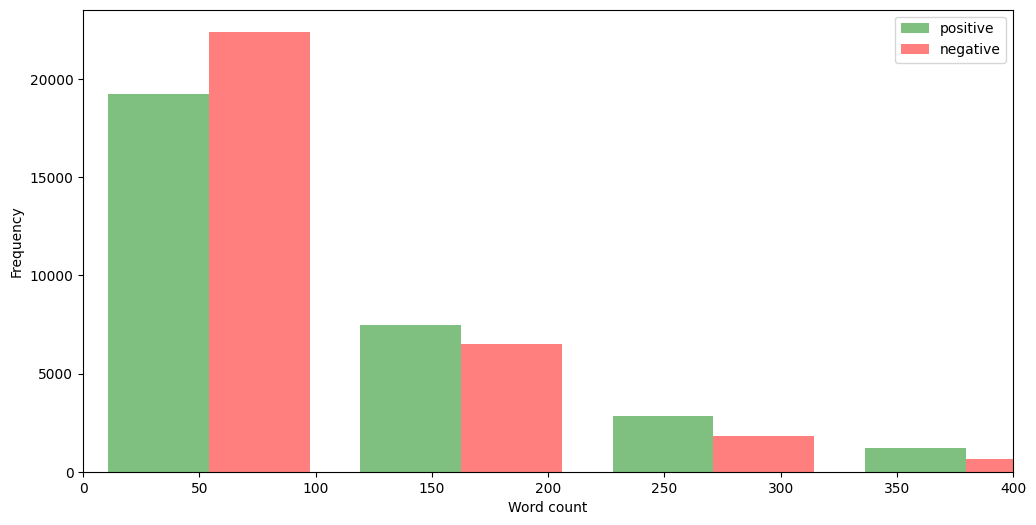

In [ ]:
# get a word count per of text
def word_count(words):
    return len(words.split())

# plot word count distribution for both positive and negative

df_all['word count'] = df_all['reviewText'].apply(word_count)

p = df_all['word count'][df_all.overall == 1]
n = df_all['word count'][df_all.overall == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,400)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'], bins=50)
plt.legend(loc='upper right')

In [ ]:
df_all = df_all.drop(['word count'], axis=1)

In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
wordLemm = WordNetLemmatizer()


def process_reviews(review):
    # Lower Casing
    review = review.lower()
    #Remove punctuations
    review = review.translate(str.maketrans("","",string.punctuation))
    #tokenizing words(test to words)
    tokens = word_tokenize(review)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]  # list
    #reducing a word to its word stem using lemmatization
    #The WordNetLemmatizer is a tool for lemmatizing words in the English language.
    # Lemmatization is the process of reducing words to their base or dictionary form (lemma) to simplify analysis and improve accuracy.
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [ ]:
#o ensure that all values in the 'reviewText' column are treated as strings, regardless of their original data type.
df_all['reviewText'] = df_all['reviewText'].astype('str')

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
df_all['processed_reviews'] = df_all['reviewText'].apply(lambda x: process_reviews(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
df_all

,reviewText,overall,processed_reviews
114050,"My stepdad needed a shower chair, and the ones...",1,stepdad needed shower chair one local store fa...
329492,It works. However it had a lot of bubbles ins...,1,work however lot bubble inside chipped big jun...
245270,We bought these for my 8 year old with high-fu...,1,bought year old highfunctioning autism easily ...
195288,I've owned a front-loader (HE) washing machine...,1,ive owned frontloader washing machine since 20...
46761,"Good value for use in the home; not too big, n...",1,good value use home big small easily disposed ...
...,...,...,...
179920,Picked up a pair of Duracell AA batteries on a...,0,picked pair duracell aa battery vacation recha...
210206,This dried up after only one or two sparse use...,0,dried one two sparse us hardly enough make sur...
112793,I had dislocated and broken my shoulder nearly...,0,dislocated broken shoulder nearly six month ag...
44474,When I was a child I remember reading a short ...,0,child remember reading short childrens story c...


In [ ]:
X = df_all['processed_reviews'].values
y = df_all['overall'].values

In [ ]:
import nltk
import os

# Set the NLTK data path
nltk.data.path.append('/usr/local/share/nltk_data')

In [ ]:
print(X.shape)
print(y.shape)

(64000,)
(64000,)


In [ ]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
#print('No. of feature_words: ', len(vector.get_feature_names()))

Vector fitted.


In [ ]:
print(X.shape)
print(y.shape)

(64000, 139561)
(64000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)

    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    print(cf_matrix)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'YlGn',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Accuracy of model on training data : 88.66796875
Accuracy of model on testing data : 84.4375 

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      6460
           1       0.84      0.85      0.84      6340

    accuracy                           0.84     12800
   macro avg       0.84      0.84      0.84     12800
weighted avg       0.84      0.84      0.84     12800

[[5426 1034]
 [ 958 5382]]


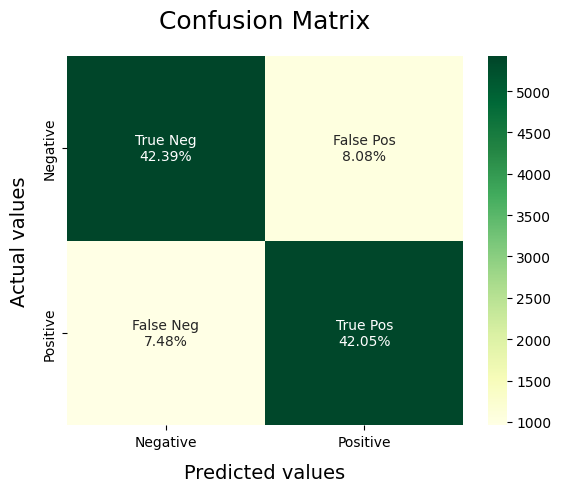

In [ ]:
lg = LogisticRegression()
lg.fit(X_train, y_train)
model_Evaluate(lg)

In [ ]:
import pickle

file = open('vectoriser.pickle','wb')
pickle.dump(vector, file)
file.close()

file = open('logisticRegression.pickle','wb')
pickle.dump(lg, file)
file.close()


In [ ]:
def load_models():
    # Load the vectoriser.
    file = open('vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('logisticRegression.pickle', 'rb')
    lg = pickle.load(file)
    file.close()
    return vectoriser, lg

In [ ]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    processes_text=[process_reviews(sen) for sen in text]
    textdata = vectoriser.transform(processes_text)
    sentiment = model.predict(textdata)

    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [ ]:
if __name__=="__main__":
    # Loading the models.
    vectoriser, lg = load_models()

    # Text to classify should be in a list.
    text = ["Such an amazing trimmer. It is a must buy for anyone who is thinking to buy a trimmer. It is a multipurpose trimmer which has got 10 modes with custom settings. Completely satisfied with the purchase.",
            "Absolute garbage. Do not buy this, I would give this zero star if possible.",
            "Definitely worth it if you can sell one of your kidney to afford it. The price makes it really unique from all other products."]

    df = predict(vectoriser, lg, text)
    print(df.head())

                                                text sentiment
0  Such an amazing trimmer. It is a must buy for ...  Positive
1  Absolute garbage. Do not buy this, I would giv...  Negative
2  Definitely worth it if you can sell one of you...  Positive
